### Replan Central:

We are currently plotting 3 proton channels:
  - P1: 0.8-4 MeV
  - P2: 4-9 MeV
  - P5: 40-90 MeV
  
__GOES HRC proxy is computed as:__

``HRC_PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6``

where P4, P5 and P6 are corresponding proton channels from

https://services.swpc.noaa.gov/text/goes-energetic-proton-flux-primary.txt

Label: P1 = Protons from 0.7 -   4 MeV units #/cm2-s-sr-MeV<br>
Label: P2 = Protons from   4 -   9 MeV units #/cm2-s-sr-MeV<br>
Label: P3 = Protons from   9 -  15 MeV units #/cm2-s-sr-MeV<br>
Label: P4 = Protons from  15 -  40 MeV units #/cm2-s-sr-MeV<br>
Label: P5 = Protons from  38 -  82 MeV units #/cm2-s-sr-MeV<br>
Label: P6 = Protons from  84 - 200 MeV units #/cm2-s-sr-MeV<br>
Label: P7 = Protons from 110 - 900 MeV units #/cm2-s-sr-MeV<br>
Label: P8 = Protons from 350 - 420 MeV units #/cm2-s-sr-MeV<br>
Label: P9 = Protons from 420 - 510 MeV units #/cm2-s-sr-MeV<br>
Label: P10= Protons from 510 - 700 MeV units #/cm2-s-sr-MeV<br>
Label: P11= Protons from      >700 MeV units #/cm2-s-sr-MeV<br>
Source: GOES-14

Archival GOES data since 2015 can be found at ``ftp://ftp.swpc.noaa.gov/pub/lists/pchan/``

__GOES-16__ data can be found at ``https://services.swpc.noaa.gov/json/goes/primary/``

__NOTE:__ GOES-16 flux units are ``per keV`` and not ``per MeV`` as for the earlier GOES satellites.

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from Ska.tdb import msids
from Ska.engarchive import fetch as fetch
import json
import requests
import os
from ftplib import FTP

In [49]:
from astropy.table import Table
from astropy.io import ascii
import json

In [50]:
NAMES = ['YR', 'MO', 'DA', 'HHMM', 'Day1', 'Day2', 'P1', 'P2', 'P3',
         'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']

## Change in the value of GOES HRC proxy

In [51]:
def calc_hrc_proxy(p4, p5, p6):
    return 6000 * p4 + 270000 * p5 + 100000 * p6

def get_protons(fname):
    protons = Table.read(fname, format='ascii', names=NAMES)
    hrc_proxy = calc_hrc_proxy(protons['P4'], protons['P5'], protons['P6'])
    protons['hrc_proxy'] = hrc_proxy
    return protons

def plot_hrc_proxy(fname, protons, label=''):
    plt.plot(protons['hrc_proxy'] / 256, label=label)
    plt.ylabel('GOES HRC proxy / 256')
    plt.ylim(1, 30)
    
def compare_protons(fnames, protons):

    colors = []
    for i in range(len(protons)):
        colors.append(f'C{i}')
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P4'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P4')
    plt.grid()

    plt.subplot(1, 3, 2)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P5'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P5')
    plt.grid()

    plt.subplot(1, 3, 3)
    for f, p, c in zip(fnames, protons, colors):
        plt.plot(p['P6'], color=c, alpha=0.7, label=f[:8])
    plt.legend()
    plt.title('P6')
    plt.grid()

In [52]:
f0 = '20150530_Gp_pchan_5m.txt'
p0 = get_protons(f0)

f1 = '20170101_Gp_pchan_5m.txt'
p1 = get_protons(f1)

f2 = '20190701_Gp_pchan_5m.txt'
p2 = get_protons(f2)

f3 = '20190707_Gp_pchan_5m.txt'
p3 = get_protons(f3)

f4 = '20190708_Gp_pchan_5m.txt'
p4 = get_protons(f4)

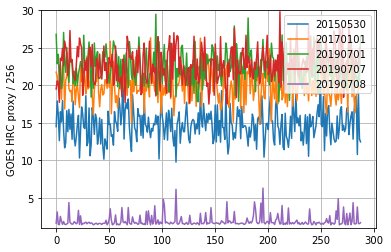

In [53]:
plot_hrc_proxy(f0, p0, label=f0[:8])
plot_hrc_proxy(f1, p1, label=f1[:8])
plot_hrc_proxy(f2, p2, label=f2[:8])
plot_hrc_proxy(f3, p3, label=f3[:8])
plot_hrc_proxy(f4, p4, label=f4[:8])
plt.legend(loc=1)
plt.grid()

__Figure:__ The drop in GOES HRC proxy happened on 2019-07-08. On that day the source changed from GOES-15 to GOES-14.

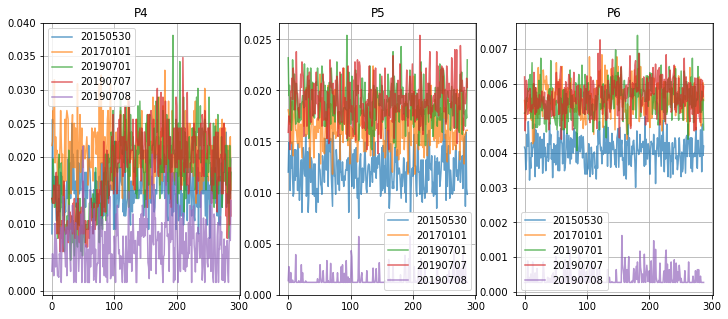

In [54]:
compare_protons([f0, f1, f2, f3, f4], [p0, p1, p2, p3, p4])

__Figure:__ The drop in GOES HRC proxy is due to much lower values of P5 and P6 starting with 2019-07-08. On that date the source changed from GOES-15 to GOES-14.

## HRC shield rate from telemetry, before and after the drop in HRC proxy value

In [55]:
def plot_hrc_shield(times, vals):
    secs = times
    hrc_shield = vals / 256.
    bad = hrc_shield < 0.1
    hrc_shield = hrc_shield[~bad]
    secs = secs[~bad]

    plt.figure(1, figsize=(6, 4))
    ticks, fig, ax = plot_cxctime(secs, hrc_shield)
    xlims = ax.get_xlim()
    dx = (xlims[1] - xlims[0]) / 20.
    ax.set_xlim(xlims[0] - dx, xlims[1] + dx)
    ax.set_ylim(min(hrc_shield.min() * 0.5, 10.0),
                max(hrc_shield.max() * 2, 300.))
    plt.plot([xlims[0] - dx, xlims[1] + dx], [235, 235], '--r')
    ax.set_yscale('log')
    plt.grid()
    plt.title('GOES proxy for HRC shield rate / 256')
    plt.ylabel('Cts / sample')
    plt.tight_layout()

In [56]:
dat = fetch.Msid('2shldart', '2019:180:00:00:00', '2019:200:00:00:00')

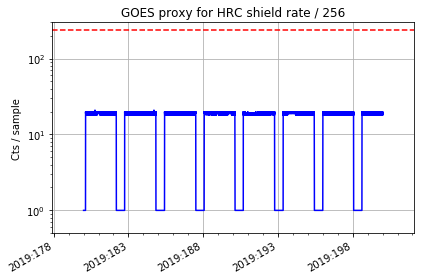

In [57]:
plot_hrc_shield(dat.times, dat.vals)

__Figure:__ Before the drop in HRC proxy value.

In [58]:
dat = fetch.Msid('2shldart', '2020:001:00:00:00', '2020:003:00:00:00')

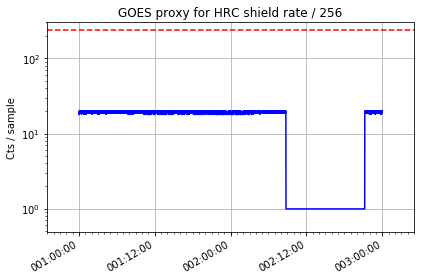

In [59]:
plot_hrc_shield(dat.times, dat.vals)

__Figure:__ After the drop in HRC proxy value. HRC shield rate is still ~20 but GOES HRC shield proxy is currently one order of magnitude lower than that.

## GOES-15 new json files, day 2020-01-21

In [60]:
with open('20200121-g15_protons_5m.json') as json_file:
    data = json.load(json_file)

In [61]:
t = Table(data)

In [62]:
t.colnames

['p10_flux',
 'p11_flux',
 'p1_flux',
 'p2_flux',
 'p3_flux',
 'p4_flux',
 'p5_flux',
 'p6_flux',
 'p7_flux',
 'p8_flux',
 'p9_flux',
 'time_tag']

In [63]:
hrc_proxy_g15 = calc_hrc_proxy(t['p4_flux'], t['p5_flux'], t['p6_flux'])

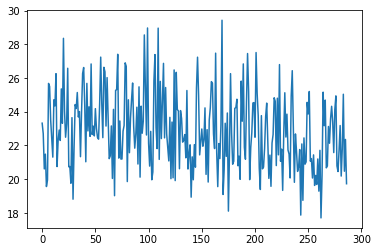

In [64]:
plt.plot(hrc_proxy_g15 / 256);

## GOES-14 new json files, day 2020-01-21

In [65]:
with open('20200121-g14_protons_5m.json') as json_file:
    data = json.load(json_file)

In [66]:
t = Table(data)

In [67]:
t.colnames

['p10_flux',
 'p11_flux',
 'p1_flux',
 'p2_flux',
 'p3_flux',
 'p4_flux',
 'p5_flux',
 'p6_flux',
 'p7_flux',
 'p8_flux',
 'p9_flux',
 'time_tag']

In [68]:
hrc_proxy_g14 = 6000 * t['p4_flux'] + 270000 * t['p5_flux'] + 100000 * t['p6_flux']

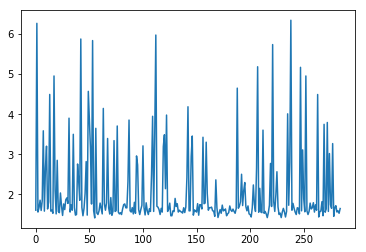

In [69]:
plt.plot(hrc_proxy_g14 / 256);

## GOES-16 new json files, day 2020-01-21

In [70]:
URL = 'https://services.swpc.noaa.gov/json/goes/primary/'

In [71]:
json_url = requests.get(f'{URL}/differential-protons-1-day.json')
data = json_url.json()

In [92]:
t = Table(data)

In [93]:
# flux per keV, not per MeV as before
t.colnames

['energy', 'flux', 'satellite', 'time_tag']

In [94]:
t[0]

energy,flux,satellite,time_tag
str17,float64,int64,str20
1020-1860 keV,0.0025276564993,16,2020-01-27T16:05:00Z


In [95]:
elos = []
ehis = []
for row in t['energy']:
    tmp = row.split(' ')
    items = tmp[0].split('-')
    elos.append(float(items[0]))
    ehis.append(float(items[1]))

In [96]:
t['e_lo'] = elos
t['e_hi'] = ehis

In [97]:
t.sort('time_tag')

In [98]:
t[:14]

energy,flux,satellite,time_tag,e_lo,e_hi
str17,float64,int64,str20,float64,float64
1020-1860 keV,0.0025276564993,16,2020-01-27T16:05:00Z,1020.0,1860.0
99900-118000 keV,2.2652586722e-06,16,2020-01-27T16:05:00Z,99900.0,118000.0
83700-98500 keV,1.18547973216e-06,16,2020-01-27T16:05:00Z,83700.0,98500.0
5840-11000 keV,2.93912489724e-05,16,2020-01-27T16:05:00Z,5840.0,11000.0
3400-6480 keV,1.08329613795e-05,16,2020-01-27T16:05:00Z,3400.0,6480.0
276000-404000 keV,2.66586056341e-07,16,2020-01-27T16:05:00Z,276000.0,404000.0
40300-73400 keV,2.30795558309e-06,16,2020-01-27T16:05:00Z,40300.0,73400.0
2310-3340 keV,2.94496057904e-05,16,2020-01-27T16:05:00Z,2310.0,3340.0
1900-2300 keV,0.0,16,2020-01-27T16:05:00Z,1900.0,2300.0


__Table:__ GOES-16 has 13 energy channels (protons). Chanels corresponding to those used so far to compute the GOES HRC proxy are:
  * ``P4 * de_p4[0] ~ flux(11640-23270 keV) * de_p4[1] + flux(25900-38100 keV)* de_p4[2]``
  * ``P5 * de_p5[0] ~ flux(40300-73400 keV) * de_p5[0]``,
  * ``P6 * de_p6[0] ~ flux(83700-98500 keV) * de_p6[1] + flux(99900-118000 keV) * de_p6[2] + flux(115000-143000 keV) * de_p6[3] + flux(160000-242000 keV) * de_p6[4]``.

In [99]:
de_p4 = 23270 - 11640
de_p5 = 73400 - 40300
de_p6 = 242000 - 83700

In [100]:
p4_flux = 0
p5_flux = 0
p6_flux = 0
rows = []
row = []

time_tag = t['time_tag'][0]

for entry in t:
    if entry['time_tag'] != time_tag:
        # Averages
        p4_flux = p4_flux / de_p4
        p5_flux = p5_flux / de_p5
        p6_flux = p6_flux / de_p6
        # Save fluxes in ``per MeV``
        rows.append(['p4', p4_flux * 1000, 16, time_tag, 11.6, 23.27])
        rows.append(['p5', p5_flux * 1000, 16, time_tag, 40.3, 73.4])
        rows.append(['p6', p6_flux * 1000, 16, time_tag, 83.7, 242])
        # Use fluxes converted from ``per keV`` to ``per MeV``
        hrc_proxy = calc_hrc_proxy(p4_flux * 1000, p5_flux * 1000, p6_flux * 1000)
        rows.append(['hrc_proxy', hrc_proxy, 16, time_tag, 11.6, 242])
        p4_flux = 0
        p5_flux = 0
        p6_flux = 0
        time_tag = entry['time_tag']
    
    energy = entry['energy']
    if energy in ('11640-23270 keV', '25900-38100 keV'):
        p4_flux += entry['flux'] * (entry['e_hi'] - entry['e_lo'])
    if energy == '40300-73400 keV':
        p5_flux = entry['flux'] * (entry['e_hi'] - entry['e_lo'])
    if energy in ('83700-98500 keV', '99900-118000 keV',
                  '115000-143000 keV', '160000-242000 keV'):
        p6_flux += entry['flux'] * (entry['e_hi'] - entry['e_lo'])

In [101]:
for row in rows:
    t.add_row(row)

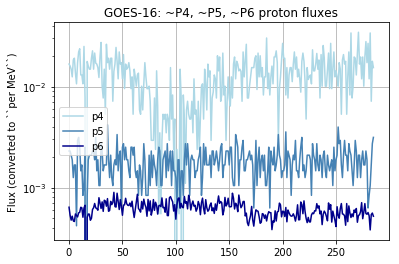

In [102]:
ok = t['energy'] == 'p4'
plt.plot(t['flux'][ok], 'lightblue', label='p4')

ok = t['energy'] == 'p5'
plt.plot(t['flux'][ok], 'steelblue', label='p5')

ok = t['energy'] == 'p6'
plt.plot(t['flux'][ok], 'darkblue', label='p6')

plt.legend()
plt.ylabel('Flux (converted to ``per MeV``)')
plt.title('GOES-16: ~P4, ~P5, ~P6 proton fluxes')
plt.yscale('log')
plt.grid()

__Figure:__ GOES 16 ~P5 and ~P6 fluxes are ~one order of mag lower than in G14/15. The current understanding is that this is due to much higher sensitivity and lower noise level of G16. Archival data at higher proton fluxes are needed in order to confirm that HRC proxy formula still applies to the G16 data.

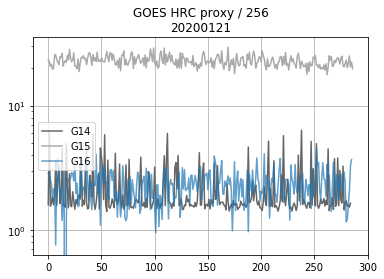

In [83]:
ok = t['energy'] == 'hrc_proxy'
plt.plot(hrc_proxy_g14 / 256, '#666666', label='G14')
plt.plot(hrc_proxy_g15 / 256, '#aaaaaa', label='G15')
plt.plot(t['flux'][ok] / 256, label='G16', alpha=0.7)

plt.legend()
plt.title('GOES HRC proxy / 256\n20200121')
plt.grid()
plt.yscale('log')

__Figure:__ G16 and G14 HRC proxies are consistent with each other. The current understanding is that in all cases, G15, G14, G16, we see a noise level in this calculation, just at a different ``sensitivity level``. Need high proton flux data to confirm that G14/G16 proxies would match the G15 proxy out of a quiet period.

## GOES source in the archival 2015-2020 data

In [84]:
"""
date1 = '2015-05-30T00:00:00.00'
date2 = '2020-01-23T00:00:00.00'

ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()

ftp.cwd("/pub/lists/pchan/")

rows = []
row = {}

mjd = DateTime(date1).mjd
while mjd < DateTime(date2).mjd:
    date = DateTime(mjd, format='mjd').fits
    tmp = date.replace("-", "")[:8]
    filename = f"{tmp}_Gp_pchan_5m.txt"
    local_filename = "tmp_protons.txt"
    
    # retrieve the file
    lf = open(local_filename, "wb")
    ftp.retrbinary("RETR " + filename, lf.write, 8*1024)
    lf.close()
    
    with open(local_filename) as lf:
        for line in lf:
            if 'Source' in line:
                satellite = line.strip()[-2:]
                row = {'satellite': satellite, 'time_mjd': mjd}
                break

    dat = ascii.read(local_filename, data_start=2)
    
    dat = Table(dat, names=NAMES)
    
    row.update({'median_p4': np.median(dat['P4']),
                 'median_p5': np.median(dat['P5']),
                 'median_p6': np.median(dat['P6'])})
    
    rows.append(row)

    mjd = mjd + 1

ftp.close()

t = Table(rows)

t.write('goes-2015-05-30-2020-01-22.dat', format='ascii')
""";

In [37]:
t = Table.read('goes-2015-05-30-2020-01-22.dat', format='ascii')

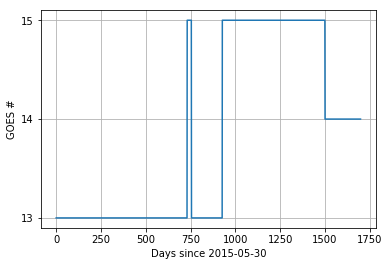

In [85]:
plt.plot(t['satellite'])
plt.yticks([13, 14, 15], ["13", "14", "15"])
plt.xlabel("Days since 2015-05-30")
plt.ylabel("GOES #")
plt.grid()

## Identify high P4, P5, P6 periods in the archival 2015-2020 data

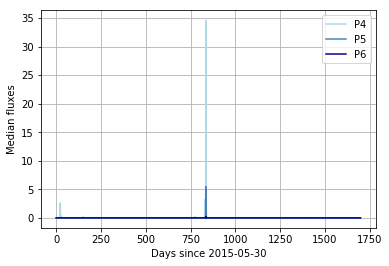

In [87]:
plt.plot(t['median_p4'], 'lightblue', label='P4')
plt.plot(t['median_p5'], 'steelblue', label='P5')
plt.plot(t['median_p6'], 'darkblue', label='P6')
plt.legend()
plt.xlabel("Days since 2015-05-30")
plt.ylabel("Median fluxes")
plt.grid()

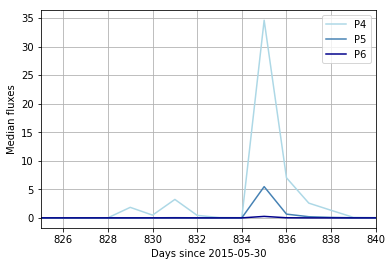

In [88]:
plt.plot(t['median_p4'], 'lightblue', label='P4')
plt.plot(t['median_p5'], 'steelblue', label='P5')
plt.plot(t['median_p6'], 'darkblue', label='P6')
plt.legend()
plt.xlabel("Days since 2015-05-30")
plt.ylabel("Median fluxes")
plt.xlim(825, 840)
plt.grid()

In [89]:
t[833:839]

median_p4,median_p5,median_p6,satellite,time_mjd
float64,float64,float64,str2,float64
0.0647,0.0153,0.00498,13,58004.9992224
0.0407,0.0166,0.00532,13,58005.9992224
34.6,5.475,0.2675,13,58006.9992224
7.025,0.663,0.02705,13,58007.9992224
2.59,0.211,0.0106,13,58008.9992224
1.33,0.0883,0.007,13,58009.9992224


In [90]:
[DateTime(tt, format='mjd').date for tt in t['time_mjd'][833:839]]

['2017:251:23:58:52.816',
 '2017:252:23:58:52.816',
 '2017:253:23:58:52.816',
 '2017:254:23:58:52.816',
 '2017:255:23:58:52.816',
 '2017:256:23:58:52.816']

__We need G-16 data from the high proton flux period of 2017:251 - 217:256 to confirm that the HRC proxy formula is working with the G-16 data__

## Level 1 and 2 available archival GOES-16 data exploration

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/

The data cover only a low energy band, from 80 keV to 12 MeV.

In [ ]:
from netCDF4 import Dataset

In [46]:
"""
Remote OPeNDAP-hosted datasets can be accessed for reading over http
if a URL is provided to the Dataset constructor instead of a filename.
However, this requires that the netCDF library be built with OPenDAP
support, via the --enable-dap configure option (added in version 4.0.1).
"""
URL_L1B = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/"
URL_L2 = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/"

### Level 1

In [47]:
# url = f"{URL_L1B}/seis-l1b-sgps/2020/01/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
# url = f"/home/malgosia/git/wip/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
url = f"/home/malgosia/git/wip/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc"
nc = Dataset(url, "r", format="NETCDF4")

In [48]:
nc.variables.keys()

odict_keys(['T1_DifferentialProtonFluxes', 'T1_DifferentialProtonFluxUncertainties', 'T1_DifferentialProtonFluxDQFs', 'T2_DifferentialProtonFluxes', 'T2_DifferentialProtonFluxUncertainties', 'T2_DifferentialProtonFluxDQFs', 'T3_DifferentialProtonFluxes', 'T3_DifferentialProtonFluxUncertainties', 'T3_DifferentialProtonFluxDQFs', 'T3P11_IntegralProtonFlux', 'T3P11_IntegralProtonFluxUncertainties', 'T3P11_IntegralProtonFluxDQFs', 'L1a_EngData_Flag', 'L1a_SciData_Flag', 'L1b_Processing_Flag', 'N_blocks', 'Instrument_Mode', 'Instrument_Serial_Number', 'Diff31_Logic_Flags', 'L1a_SciData_TimeStamp', 'quaternion_Q0', 'quaternion_Q1', 'quaternion_Q2', 'quaternion_Q3', 'ECEF_X', 'ECEF_Y', 'ECEF_Z', 'yaw_flip_flag', 'eclipse_flag', 'solar_array_current', 'sgps_telemetry_time', 'sgps_sensor_temperature', 'product_time', 'sensor_unit_label', 'energy_T1_label', 'energy_T2_label', 'energy_T3_label', 'Diff31_logic_channel_label', 'solar_array_current_channel_index_label', 'percent_uncorrectable_L0_err

In [49]:
nc.variables['T3_DifferentialProtonFluxes']

<class 'netCDF4._netCDF4.Variable'>
float32 T3_DifferentialProtonFluxes(report_number, sensor_unit, energy_T3)
    _FillValue: -1e+31
    units: cm-2 sr-1 s-1 keV-1
    long_name: differential proton flux at specific energy bands for telescope 3's primary proton data channels on each of the two sensor units
    valid_range: [-9999999.  9999999.]
unlimited dimensions: report_number
current shape = (86399, 2, 5)
filling on

In [50]:
data = nc.variables['T3_DifferentialProtonFluxes'][:]

In [51]:
data

array([[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   3.10581127e-05,
           0.00000000e+00,   0.00000000e+00],
        [  3.74531046e-05,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]],

       ..., 
       [[  0.00000000e+00,   0.00000000e+00,   3.10584837e-05,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]

In [52]:
nc.variables['energy_T3_label']

<class 'netCDF4._netCDF4.Variable'>
|S1 energy_T3_label(energy_T3, energy_T3_str_len)
    long_name: labels for five energy bands reported from telescope 3 spanning from 80 to 500 MeV. labels are ordered the same as applicable data variables
unlimited dimensions: 
current shape = (5, 26)
filling on, default _FillValue of   used

In [53]:
labels = nc.variables['energy_T3_label'][:]

In [54]:
labels

masked_array(data =
 [[b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'A'
  b'F' b':' b'8' b'3' b'-' b'9' b'9' b'M' b'e' b'V' -- --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'B'
  b'F' b':' b'9' b'9' b'-' b'1' b'1' b'8' b'M' b'e' b'V' --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'8' b'C'
  b'F' b':' b'1' b'1' b'8' b'-' b'1' b'5' b'0' b'M' b'e' b'V']
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'9' b'F'
  b':' b'1' b'5' b'0' b'-' b'2' b'7' b'5' b'M' b'e' b'V' --]
 [b'E' b'n' b'e' b'r' b'g' b'y' b'B' b'a' b'n' b'd' b'-' b'P' b'1' b'0'
  b':' b'2' b'7' b'5' b'-' b'5' b'0' b'0' b'M' b'e' b'V' --]],
             mask =
 [[False False False False False False False False False False False False
  False False False False False False False False False False False False
   True  True]
 [False False False False False False False False False False False False
  False False False False False False False False Fals

In [55]:
for d in labels.data:
    label = ('').join([dd.decode("utf-8") for dd in d])
    print(label)

EnergyBand-P8AF:83-99MeV
EnergyBand-P8BF:99-118MeV
EnergyBand-P8CF:118-150MeV
EnergyBand-P9F:150-275MeV
EnergyBand-P10:275-500MeV


### Level 2

In [56]:
# url = "{URL_L2}/data/mpsh-l2-avg5m/2020/01/sci_mpsh-l2-avg5m_g16_d20200101_v1-0-2.nc"
url = "/home/malgosia/git/wip/sci_mpsh-l2-avg5m_g16_d20200101_v1-0-2.nc"
nc = Dataset(url,'r')

In [57]:
nc.variables.keys()

odict_keys(['L2_SciData_TimeStamp', 'L1bRecordsInAvg', 'YawFlipFlag', 'EclipseFlag', 'AvgDiffProtonFlux', 'AvgDiffProtonFluxUncert', 'DiffProtonValidL1bSamplesInAvg', 'DiffProtonDQFdtcSum', 'DiffProtonDQFoobSum', 'DiffProtonDQFerrSum', 'AvgDiffElectronFlux', 'AvgDiffElectronFluxUncert', 'DiffElectronEffectiveEnergy', 'DiffElectronValidL1bSamplesInAvg', 'DiffElectronDQFdtcSum', 'DiffElectronDQFoobSum', 'DiffElectronDQFerrSum', 'AvgIntElectronFlux', 'AvgIntElectronFluxUncert', 'IntElectronEffectiveEnergy', 'IntValidL1bSamplesInAvg', 'IntDQFdtcSum', 'IntDQFoobSum', 'IntDQFerrSum', 'DiffProtonLowerEnergy', 'DiffProtonUpperEnergy', 'DiffProtonEffectiveEnergy', 'ExpectedLUTNotFound'])

In [58]:
nc.variables['DiffProtonLowerEnergy']

<class 'netCDF4._netCDF4.Variable'>
float32 DiffProtonLowerEnergy(telescopes, proton_diff_chans)
    _FillValue: -9999.0
    long_name: Lower band energies for the MPS-HI proton differential channels P1-P11
    units: keV
    valid_min: 0.0
unlimited dimensions: 
current shape = (5, 11)
filling on

In [59]:
nc.variables['DiffProtonLowerEnergy'][:]

array([[   80.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   84.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   90.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   93.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.],
       [   81.,   105.,   148.,   212.,   309.,   536.,   720.,  1000.,
         1900.,  3200.,  6500.]], dtype=float32)

In [60]:
nc.variables['DiffProtonUpperEnergy'][:]

array([[   119.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   117.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   130.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   126.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.],
       [   114.,    148.,    212.,    309.,    536.,    720.,   1000.,
          1900.,   3200.,   6500.,  12000.]], dtype=float32)

In [61]:
# nc.variables['energy_proton_label']
nc.variables['DiffProtonUpperEnergy']

<class 'netCDF4._netCDF4.Variable'>
float32 DiffProtonUpperEnergy(telescopes, proton_diff_chans)
    _FillValue: -9999.0
    long_name: Upper band energies for the MPS-HI proton differential channels P1-P11
    units: keV
    valid_min: 0.0
unlimited dimensions: 
current shape = (5, 11)
filling on

In [62]:
nc.variables['AvgDiffProtonFlux']

<class 'netCDF4._netCDF4.Variable'>
float32 AvgDiffProtonFlux(record_number, telescopes, proton_diff_chans)
    _FillValue: -1e+31
    long_name: Time-averaged proton fluxes in several differential channels between 80 and 10,000 keV
    units: protons/(cm^2 sr keV s)
    valid_min: 0.0
    valid_max: 460000.0
unlimited dimensions: record_number
current shape = (288, 5, 11)
filling on